# P9 - Clustering, ACP et visualisation

<div class="alert alert-warning" role="alert"><b>
Attention: les différents commentaires présents dans ce notebook ont étés réalisés à un instant T après l'exécution de la totalité du code. Si le code dans le notebook a été ré-exécuté entre temps, il est possible que certaines valeurs / composition ou noms de cluster ne correspondent pas entre les graphs et les commentaires. C'est notamment le cas pour les kmeans qui dépendent d'élements aléatoires (ex: centroïdes de base) et peuvent faire varier les résultats d'une exécution à l'autre. Les résultats de l'analyse et recommandations en fin de notebook n'en sont cependant pas moins pertinents et peuvent être utilisés afin de répondre à notre problématique.
</div>

# 0. Setup

# 0.1 Import des libraries

In [136]:
# import des librar utilisées
import pandas as pd 

import numpy as np

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.ticker as ticker


import seaborn as sns

import plotly.express as px

from collections import defaultdict

# 0.1 Création des fonctions

In [2]:
# Fonction permettant de setup les label des graphs de projections factorielles en ne faisant apparaitre qu'un seul cluster
# pour faciliter l'analyse du graph et limiter le bruit 

def cluster_names(cluster_number):
    cluster_name_list = []
    for index, row in df_cluster.iterrows():
        if row["Cluster"] == cluster_number:
            cluster_name_list.append(index)
        else:
            cluster_name_list.append("")
    return cluster_name_list


In [3]:
# Fonction permettant la création des graphs de corrélations qui serviront à analyser notre ACP: 

def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(25,22))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # setup des flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],
                head_width=0.04,
                head_length=0.04, 
                width=0.01, )
        
        # création de valeur aléatoire qui vont permettre d'éviter le chevauchement des labels dans le graph
        random_value_A = np.random.uniform(0.00,0.07)
        random_value_B = np.random.uniform(0.00,0.07)

        # setup des labels en utilisant les valeurs aléatoires précédemment définies
        plt.text(pca.components_[x, i]+ random_value_A,
                 pca.components_[y, i]+ random_value_B,
                features[i])  
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Nommage du graph de correlations
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Création du cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Setup axes et display
    plt.axis('equal')
    plt.show(block=False)

In [4]:
# Fonction permettant de créer les graphiques de plans factoriels qui permettent 
# d'analyser les individus par clusters après réduction des variables via l'ACP : 

def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Setup des points 
    palette = sns.color_palette(n_colors=len(set(clusters)))
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=palette)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


# Réalisation d'un ACP sur la base du tableau "df_tableau_analyse"

# 1. Préparation

## 1.1 Import des données

In [5]:
# Chargement du fichier pre-traîté

df = pd.read_csv("tableau_analyse.csv", decimal=".", index_col=0, encoding='latin-1')
df.head()

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant)
Zone,,,,,,,,,,,,,,
Afghanistan,6.0,0.0,36.0,28.0,12.970148,2.316810,508.453722,40099.462,31.618301,0.254138,-2.73,9,0.001671,0.000698
Afrique du Sud,140.0,49.0,425.0,1881.0,3062.256423,-15.113259,5094.384038,59392.255,11.755044,0.672612,-0.24,40,0.034803,0.031671
Albanie,71.0,0.0,26.0,14.0,1069.861314,-3.080819,5180.914198,2854.710,-1.296006,0.637411,0.08,5,0.014012,0.004904
Algérie,22.0,1.0,0.0,284.0,1142.640689,-15.282432,3367.963003,44177.969,18.564953,0.735321,-0.86,18,0.006338,0.006429
Allemagne,67.0,575.0,766.0,1572.0,64589.266093,-1.393035,45908.724713,83408.554,2.284599,0.767204,0.67,8,0.019494,0.018847


## 1.2 Setup options graphiques

In [6]:
# Chargement de Seaborn
sns.set()

# 2. Préparation des données

## 2.1 Vérifications usuelles

In [7]:
# visualisation tête du df : 
df.head()

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant)
Zone,,,,,,,,,,,,,,
Afghanistan,6.0,0.0,36.0,28.0,12.970148,2.316810,508.453722,40099.462,31.618301,0.254138,-2.73,9,0.001671,0.000698
Afrique du Sud,140.0,49.0,425.0,1881.0,3062.256423,-15.113259,5094.384038,59392.255,11.755044,0.672612,-0.24,40,0.034803,0.031671
Albanie,71.0,0.0,26.0,14.0,1069.861314,-3.080819,5180.914198,2854.710,-1.296006,0.637411,0.08,5,0.014012,0.004904
Algérie,22.0,1.0,0.0,284.0,1142.640689,-15.282432,3367.963003,44177.969,18.564953,0.735321,-0.86,18,0.006338,0.006429
Allemagne,67.0,575.0,766.0,1572.0,64589.266093,-1.393035,45908.724713,83408.554,2.284599,0.767204,0.67,8,0.019494,0.018847


In [8]:
# visualisation queue du df : 
df.tail()

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant)
Zone,,,,,,,,,,,,,,
Émirats arabes unis,104.0,86.0,493.0,51.0,19884.468665,-15.027324,36284.547906,9365.145,8.080537,0.919767,0.63,4,0.049012,0.005446
Équateur,81.0,0.0,0.0,333.0,1104.193903,-9.998056,5600.391520,17797.737,14.943629,0.632435,-0.36,49,0.018710,0.018710
États-Unis d'Amérique,231.0,3878.0,135.0,23150.0,95037.000000,-2.812720,63122.594145,336997.624,6.425460,0.815543,-0.02,4,0.057719,0.068695
Éthiopie,2.0,0.0,1.0,68.0,2380.977218,1.755361,840.361930,120283.026,27.349281,0.208748,-1.74,32,0.000565,0.000565
Îles Salomon,25.0,0.0,5.0,0.0,9.133470,-3.991685,2250.563757,707.851,24.673675,0.231030,0.64,9,0.005651,0.000000


In [9]:
# visualisation shape du df : 
df.shape

(184, 14)

In [10]:
# On instancie notre scaler : 
scaler = QuantileTransformer(n_quantiles=184, output_distribution='uniform')

# On le fit : 
X = df.values
scaler.fit(X)

# On l'entraine : 
X_scaled = scaler.transform(X)

# On le transforme en DataFrame : 
idx= ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
mean,0.50,0.34,0.49,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
std,0.29,0.40,0.30,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29


<div class="alert alert-info" role="alert"><b>
Info : le scaler utilisé est <i>QuantileTransformer</i> avec un setup pour une distribution uniforme. Ce choix fait suite à une analyse bivariée faisant ressortir des problématiques d'échelles notamment liées aux pays avec une très faible ou très forte population, et des variables avec une distribution suivant une loi de puissance. Après expérimentation de différentes méthode de scaling, il s'agit de celle qui semble le mieux traiter ces outliers et offrant les résultats les plus pertinents pour l'ACP / le clustering. 
</b></div>

In [137]:
# contrôle de NAN et du Dtype des variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, Afghanistan to Îles Salomon
Data columns (total 15 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles  184 non-null    float64
 1   Exportations quantité - Viande de Volailles                           184 non-null    float64
 2   Importations quantité - Viande de Volailles                           184 non-null    float64
 3   Production - Viande de Volailles                                      184 non-null    float64
 4   IDE en US$                                                            184 non-null    float64
 5   Croissance annuelle PIB US$ par habitant                              184 non-null    float64
 6   PIB US $ par habitant                                                 184 non-null  

In [12]:
df.isna().mean()

Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles    0.0
Exportations quantité - Viande de Volailles                             0.0
Importations quantité - Viande de Volailles                             0.0
Production - Viande de Volailles                                        0.0
IDE en US$                                                              0.0
Croissance annuelle PIB US$ par habitant                                0.0
PIB US $ par habitant                                                   0.0
population 2021 en milliers                                             0.0
evol pop à 10 ans                                                       0.0
% pop urbaine 2020                                                      0.0
stabilite politique 2021                                                0.0
temps implantation buisiness (j)                                        0.0
Disponibilité intérieure - Viande de Volailles (par habitant)           0.0
Production -

In [13]:
# vérification doublons individuq
df.duplicated().sum()

0

In [14]:
# visualisation nb valeurs unique pour chaque variable
df.nunique()

Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles    119
Exportations quantité - Viande de Volailles                              56
Importations quantité - Viande de Volailles                              92
Production - Viande de Volailles                                        128
IDE en US$                                                              178
Croissance annuelle PIB US$ par habitant                                184
PIB US $ par habitant                                                   184
population 2021 en milliers                                             184
evol pop à 10 ans                                                       184
% pop urbaine 2020                                                      184
stabilite politique 2021                                                141
temps implantation buisiness (j)                                         51
Disponibilité intérieure - Viande de Volailles (par habitant)           184
Production -

In [15]:
# description des variables
df.describe()

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant)
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,1.840000e+02,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,81.119565,100.880435,99.641304,841.891304,6572.123288,-6.171356,13455.400744,5.040170e+04,12.651971,0.590691,-0.118859,19.097826,0.023578,0.015752
std,64.477360,446.927442,260.390442,3042.828598,30935.428177,12.627060,18916.859974,1.847759e+05,11.759225,0.227100,0.946183,25.399565,0.019222,0.016962
min,2.000000,0.000000,0.000000,0.000000,-162703.596070,-56.485628,285.875782,1.251100e+01,-12.707748,0.119847,-2.730000,1.000000,0.000524,0.000000
25%,25.000000,0.000000,3.000000,10.000000,31.570394,-11.919622,1902.884073,2.573855e+03,4.143534,0.397276,-0.652500,7.000000,0.006649,0.001890
50%,69.000000,0.000000,19.000000,70.000000,564.827879,-4.587245,5256.843494,9.729925e+03,11.531780,0.590588,-0.035000,12.000000,0.020434,0.009840
75%,116.000000,13.000000,84.000000,318.000000,3265.038946,0.024174,15527.954209,3.312970e+04,20.141085,0.769607,0.670000,20.250000,0.034586,0.024488
max,265.000000,4047.000000,2391.000000,23150.000000,282909.560061,73.636698,117181.646629,1.457935e+06,54.582498,1.028512,1.490000,230.000000,0.086263,0.074719


## 2.4 Split de la donnée

In [16]:
X = df.values
X[:5]

array([[ 6.00000000e+00,  0.00000000e+00,  3.60000000e+01,
         2.80000000e+01,  1.29701480e+01,  2.31681000e+00,
         5.08453722e+02,  4.00994620e+04,  3.16183009e+01,
         2.54138318e-01, -2.73000000e+00,  9.00000000e+00,
         1.67084536e-03,  6.98263732e-04],
       [ 1.40000000e+02,  4.90000000e+01,  4.25000000e+02,
         1.88100000e+03,  3.06225642e+03, -1.51132590e+01,
         5.09438404e+03,  5.93922550e+04,  1.17550440e+01,
         6.72612124e-01, -2.40000000e-01,  4.00000000e+01,
         3.48025176e-02,  3.16707961e-02],
       [ 7.10000000e+01,  0.00000000e+00,  2.60000000e+01,
         1.40000000e+01,  1.06986131e+03, -3.08081900e+00,
         5.18091420e+03,  2.85471000e+03, -1.29600618e+00,
         6.37411318e-01,  8.00000000e-02,  5.00000000e+00,
         1.40119312e-02,  4.90417591e-03],
       [ 2.20000000e+01,  1.00000000e+00,  0.00000000e+00,
         2.84000000e+02,  1.14264069e+03, -1.52824320e+01,
         3.36796300e+03,  4.41779690e+04,  1.

In [17]:
type(X)

numpy.ndarray

In [18]:
X.shape

(184, 14)

In [19]:
# listing des noms des pays dans un objet 'names'
names = df.index
names

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie',
       ...
       'Viet Nam', 'Yémen', 'Zambie', 'Zimbabwe', 'Égypte',
       'Émirats arabes unis', 'Équateur', 'États-Unis d'Amérique', 'Éthiopie',
       'Îles Salomon'],
      dtype='object', name='Zone', length=184)

In [20]:
# listing des noms des variables dans un objet 'features'
features = df.columns
features

Index(['Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles',
       'Exportations quantité - Viande de Volailles',
       'Importations quantité - Viande de Volailles',
       'Production - Viande de Volailles', 'IDE en US$',
       'Croissance annuelle PIB US$ par habitant', 'PIB US $ par habitant',
       'population 2021 en milliers', 'evol pop à 10 ans',
       '% pop urbaine 2020', 'stabilite politique 2021',
       'temps implantation buisiness (j)',
       'Disponibilité intérieure - Viande de Volailles (par habitant)',
       'Production - Viande de Volailles (par habitant)'],
      dtype='object')

# 3. Concernant le PCA

## 3.1 Scaling

In [21]:
# setup du scaler
scaler = QuantileTransformer(n_quantiles=184, output_distribution='uniform')

In [22]:
# fit de la donnée
scaler.fit(X)

QuantileTransformer(n_quantiles=184)

In [23]:
# création du df fit et scale
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[0.05737705, 0.        , 0.64480874, 0.36612022, 0.19672131,
        0.86338798, 0.03825137, 0.79781421, 0.93989071, 0.08196721,
        0.        , 0.36612022, 0.06010929, 0.09289617],
       [0.81967213, 0.83606557, 0.93989071, 0.92349727, 0.73224044,
        0.15300546, 0.49180328, 0.86885246, 0.50819672, 0.60655738,
        0.44535519, 0.90163934, 0.75956284, 0.84153005],
       [0.51912568, 0.        , 0.57923497, 0.27868852, 0.59562842,
        0.55191257, 0.49726776, 0.28415301, 0.09836066, 0.54644809,
        0.54644809, 0.14480874, 0.35519126, 0.38797814],
       [0.22677596, 0.59562842, 0.        , 0.7431694 , 0.60655738,
        0.14754098, 0.36612022, 0.81420765, 0.70491803, 0.69398907,
        0.18306011, 0.69945355, 0.24043716, 0.45901639],
       [0.4726776 , 0.96721311, 0.97540984, 0.87431694, 0.9726776 ,
        0.67213115, 0.91803279, 0.89617486, 0.20218579, 0.74863388,
        0.75136612, 0.30054645, 0.47540984, 0.66120219]])

In [24]:
# Visualisation du scaling
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
mean,0.50,0.34,0.49,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
std,0.29,0.40,0.30,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29


## 3.2 PCA

In [25]:
# Choix du nombre de composantes
n_components =6

In [26]:
# création du PCA sur la base de n_components précédemment crées
pca = PCA(n_components=n_components)

In [27]:
# fit
pca.fit(X_scaled)

PCA(n_components=6)

## 3.3 Explained variance & scree plot

In [28]:
pca.explained_variance_ratio_

array([0.37842209, 0.21208261, 0.08149843, 0.06630606, 0.05758011,
       0.04808708])

In [29]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([37.84, 21.21,  8.15,  6.63,  5.76,  4.81])

In [30]:
scree_cum = scree.cumsum().round()
scree_cum

array([38., 59., 67., 74., 80., 84.])

In [31]:
x_list = range(1, n_components+1)

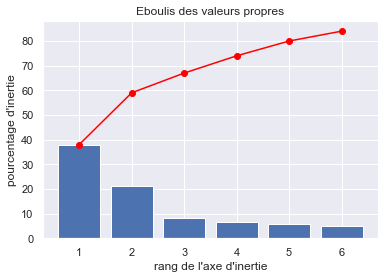

In [32]:
# visualisation de l'inertie par composante
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

<div class="alert alert-info" role="alert"><b>
Analyse : Les gains en inertie deviennent résiduels à partir de 3 composantes, 3 composantes représentent également le seuil à partir duquel est représentée quasiment 70% de l'inertie totale.
</b></div>

## 3.4 Composantes

In [33]:
pcs = pca.components_
pcs

array([[ 2.98265328e-01,  4.64156696e-01,  2.38598526e-01,
         2.40822946e-01,  2.11573973e-01, -3.38669853e-02,
         3.55191721e-01,  5.25221508e-02, -2.55358437e-01,
         3.10094820e-01,  1.74284255e-01, -1.33572417e-01,
         2.94563977e-01,  3.30892576e-01],
       [ 2.89690526e-01, -2.95405585e-01, -5.56828574e-02,
        -4.02808084e-01, -2.65240742e-01, -2.05937486e-01,
         1.80769818e-01, -5.10804351e-01, -1.00353676e-01,
         5.92320802e-02,  3.75566796e-01,  1.02935046e-04,
         3.08979906e-01, -8.36658994e-02],
       [ 2.72364596e-01, -2.30343483e-01, -2.16938602e-01,
         2.90077007e-01, -1.24786139e-01, -4.98551686e-01,
        -1.31650418e-01,  1.75917806e-01,  8.34923322e-02,
         5.77960500e-03, -2.80671460e-01,  4.22264206e-01,
         2.46416634e-01,  3.23015556e-01],
       [-2.52340103e-02, -1.17582548e-01,  4.95485496e-01,
        -9.20481420e-02,  8.43709210e-02, -5.07433093e-01,
        -3.17394712e-02,  9.56402663e-02,  4.

In [34]:
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.298265,0.464157,0.238599,0.240823,0.211574,-0.033867,0.355192,0.052522,-0.255358,0.310095,0.174284,-0.133572,0.294564,0.330893
1,0.289691,-0.295406,-0.055683,-0.402808,-0.265241,-0.205937,0.180770,-0.510804,-0.100354,0.059232,0.375567,0.000103,0.308980,-0.083666
2,0.272365,-0.230343,-0.216939,0.290077,-0.124786,-0.498552,-0.131650,0.175918,0.083492,0.005780,-0.280671,0.422264,0.246417,0.323016
3,-0.025234,-0.117583,0.495485,-0.092048,0.084371,-0.507433,-0.031739,0.095640,0.406247,0.300246,-0.148141,-0.364711,-0.012380,-0.215639
4,0.061403,-0.267661,-0.476529,0.113669,0.189459,-0.034895,-0.050512,-0.002548,-0.064507,-0.095033,-0.074121,-0.755064,0.063003,0.228342
5,-0.242378,0.228956,0.114988,0.033841,-0.413749,-0.477929,-0.094843,0.008702,-0.568186,-0.246658,0.002173,-0.174929,-0.225306,0.027314


In [35]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant)
F1,0.30,0.46,0.24,0.24,0.21,-0.03,0.36,0.05,-0.26,0.31,0.17,-0.13,0.29,0.33
F2,0.29,-0.30,-0.06,-0.40,-0.27,-0.21,0.18,-0.51,-0.10,0.06,0.38,0.00,0.31,-0.08
F3,0.27,-0.23,-0.22,0.29,-0.12,-0.50,-0.13,0.18,0.08,0.01,-0.28,0.42,0.25,0.32
F4,-0.03,-0.12,0.50,-0.09,0.08,-0.51,-0.03,0.10,0.41,0.30,-0.15,-0.36,-0.01,-0.22
F5,0.06,-0.27,-0.48,0.11,0.19,-0.03,-0.05,-0.00,-0.06,-0.10,-0.07,-0.76,0.06,0.23
F6,-0.24,0.23,0.11,0.03,-0.41,-0.48,-0.09,0.01,-0.57,-0.25,0.00,-0.17,-0.23,0.03


In [36]:
transposed_pcs = pcs.T

<AxesSubplot:>

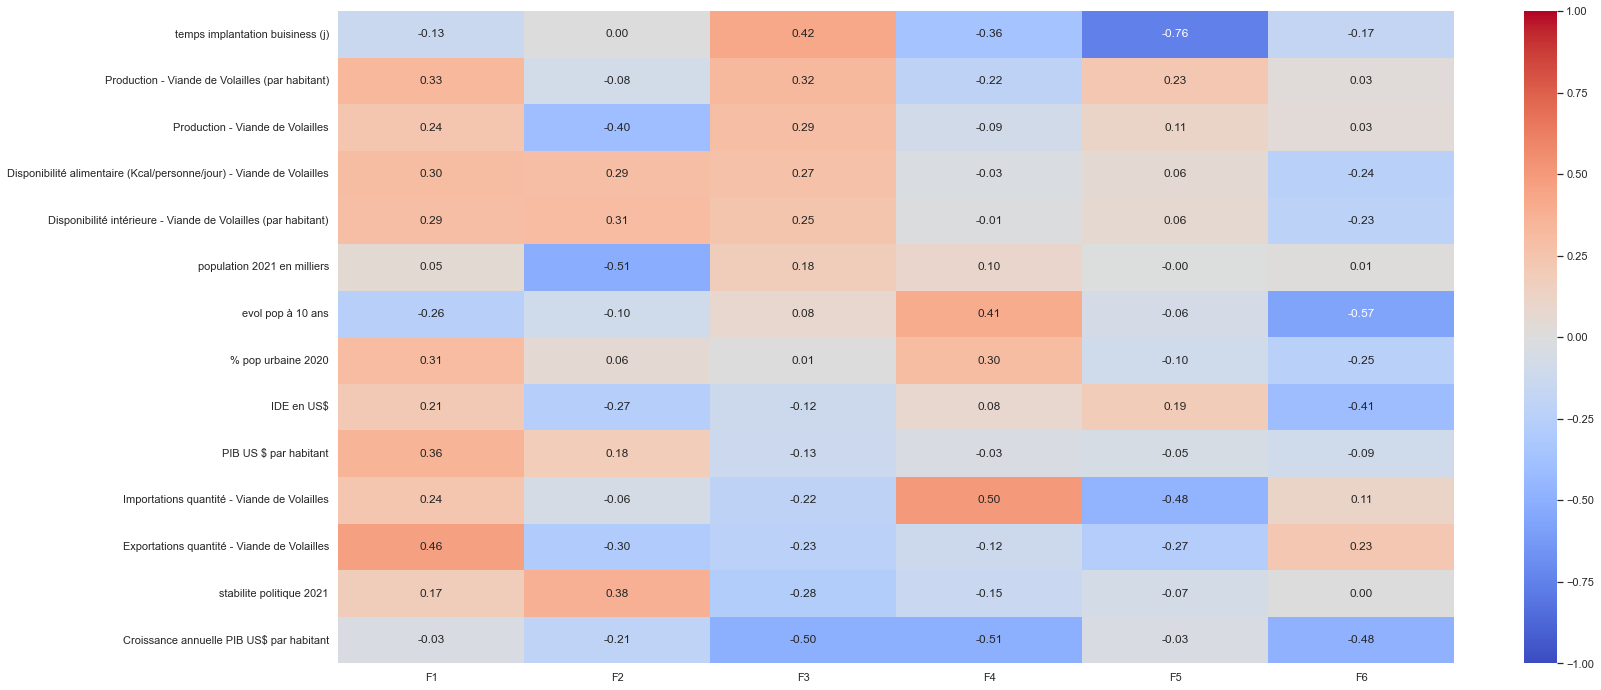

In [37]:
# génère la heatmap de correlation 
fig, ax = plt.subplots(figsize=(25, 12))
sns.heatmap(transposed_pcs.sort_values(by=['F3'],ascending=False), vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f") 

##### 3.5 Graphs de corrélations

In [38]:
x, y = 0,1

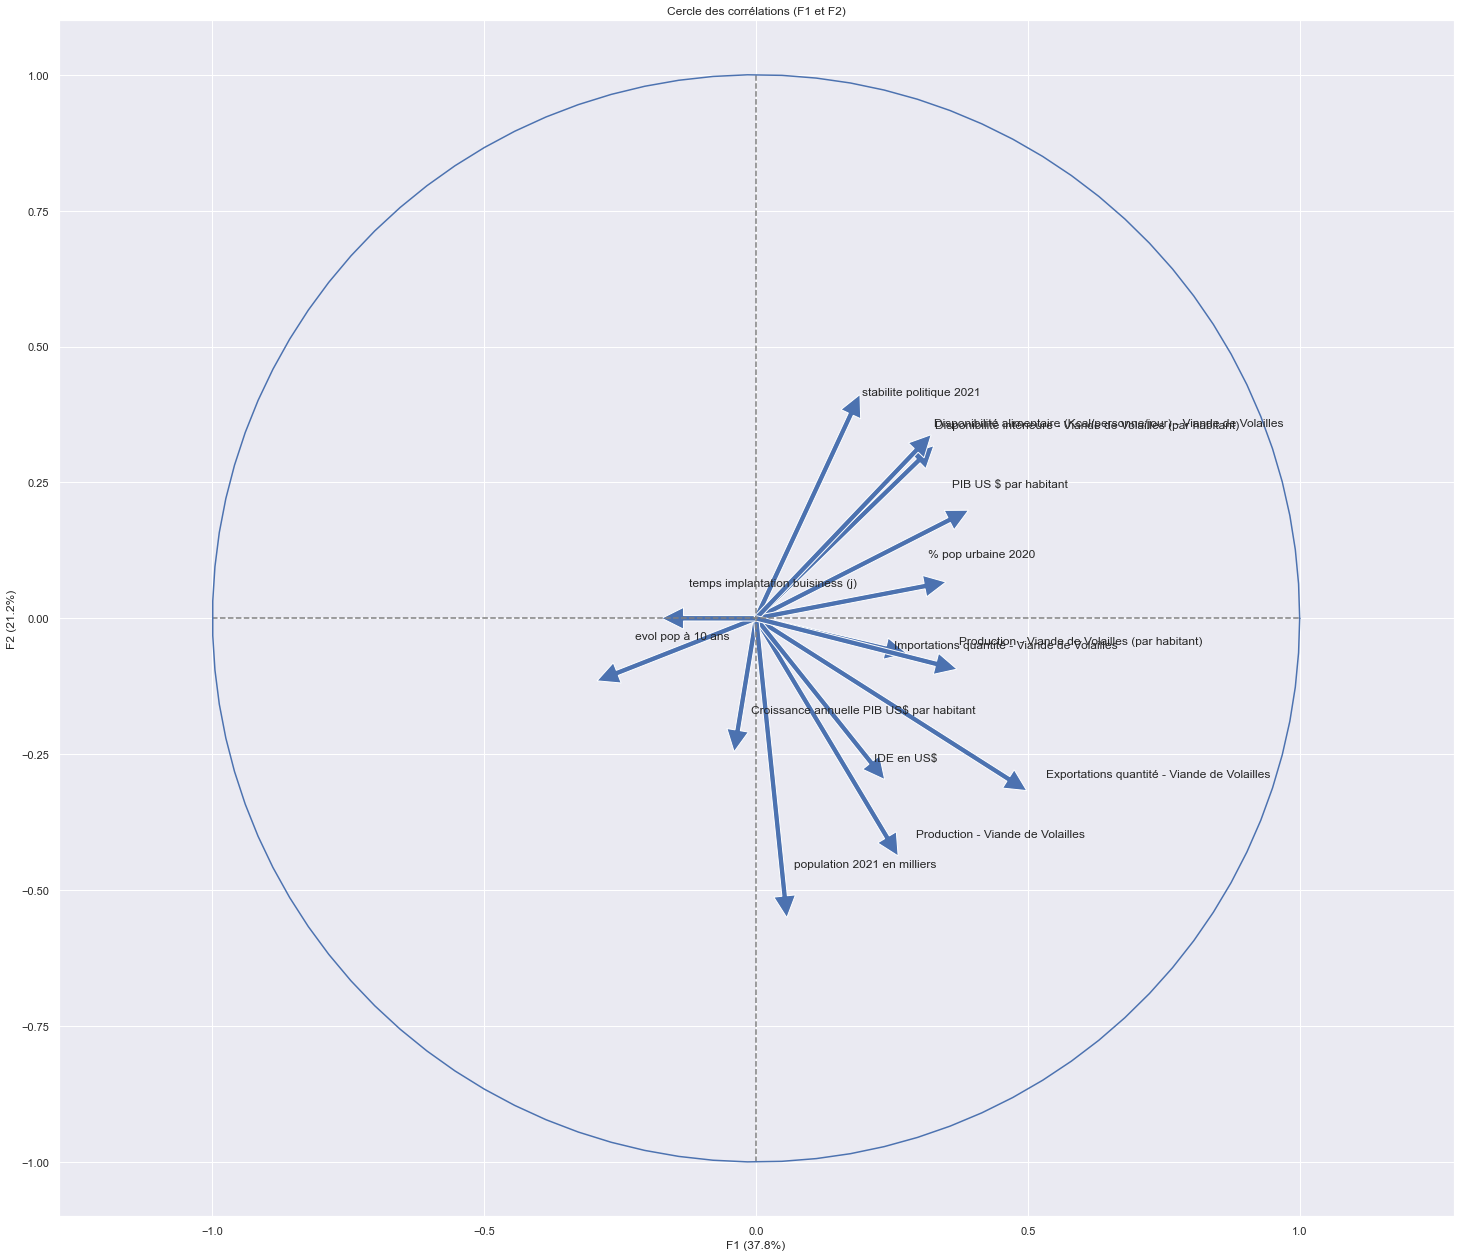

In [39]:
# visualisation cercle de corrélation
correlation_graph(pca, (0,1),features)

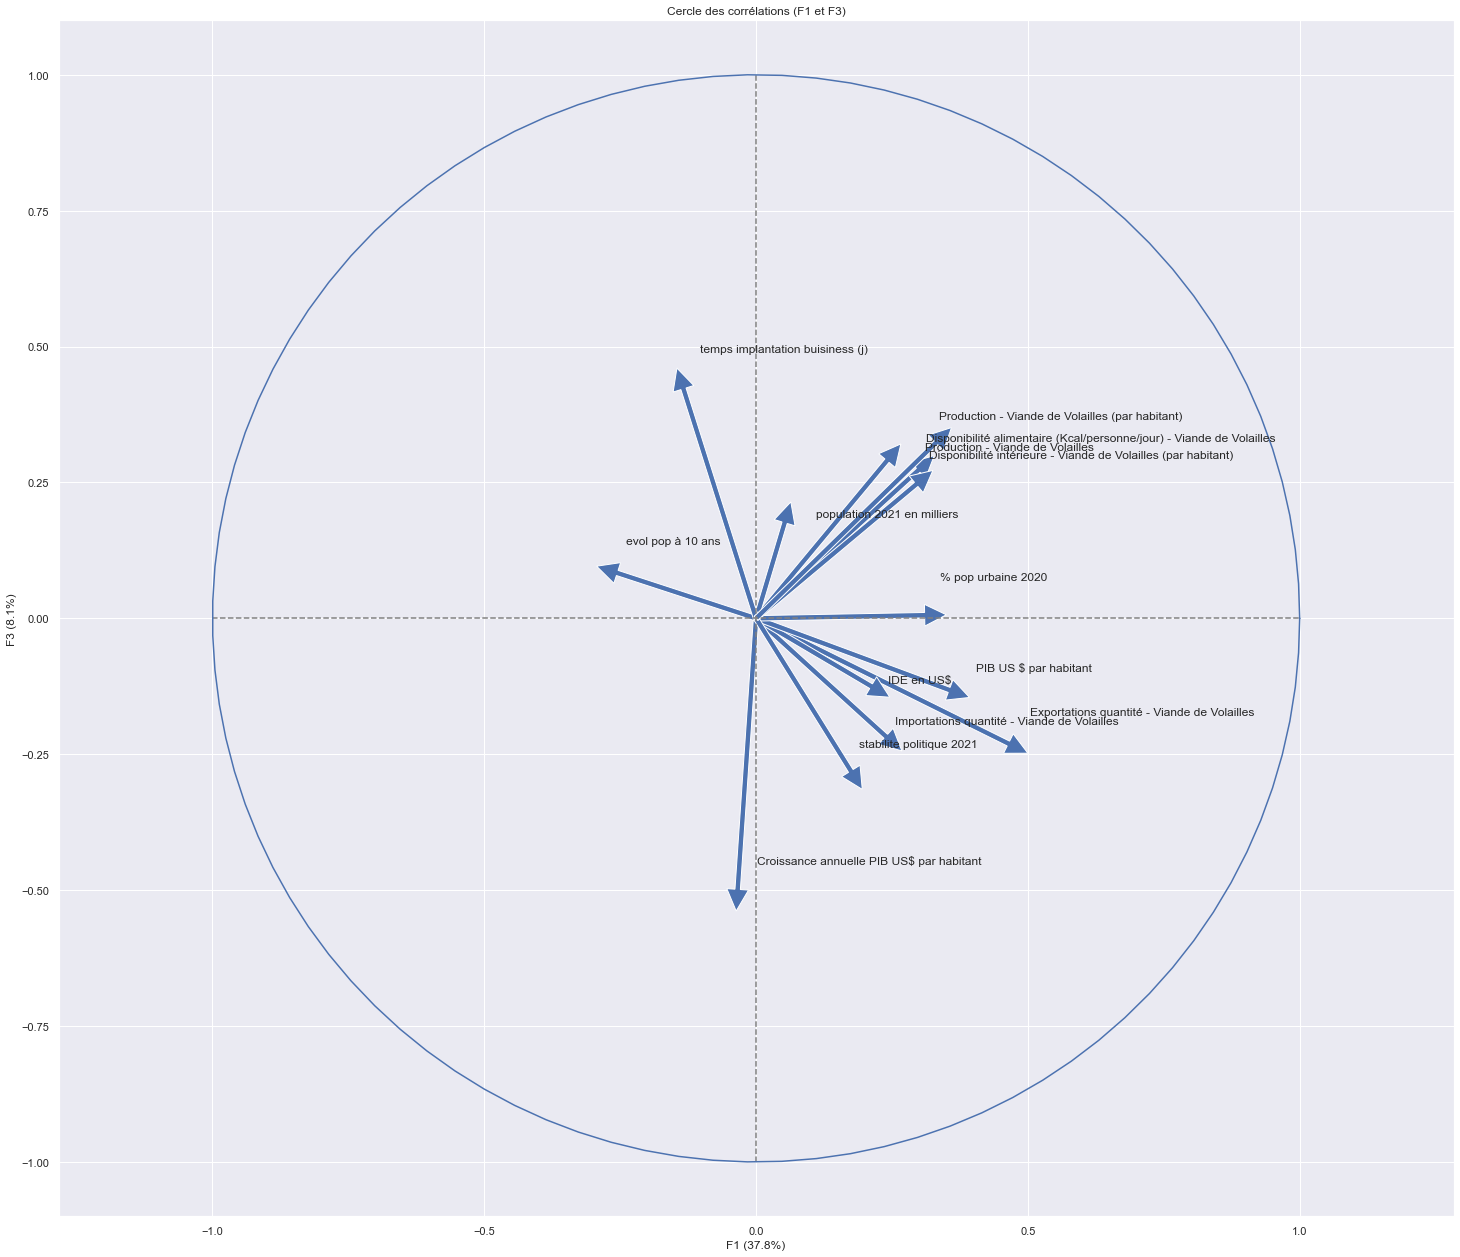

In [40]:
# visualisation cercle de corrélation
correlation_graph(pca, (0,2),features)

<div class="alert alert-info" role="info"><b>
Analyse des composantes:
    
.
    
F1 = Développement
- Exportation (+)
- PIB (+)
- Production (+)
- Pop urbaine % (+)
- Evol pop à 10 ans (-)

Ciblage F1: Idéalement viser les individus qui ont une valeur plutôt négative sur F1 car la variable exportation a une corrélation positive forte.

F2 = Démographie et stabilité
- Stabilité (+)
- Disponibilité intérieure/hab (+)
- Disponibilité alimentaire/hab (+)
- Population (-)
- Production (-)
- Exportation (-) 
    
Ciblage F2: Idéalement cibler les individus avec une valeur positive sur F2 car la variable stabilité est très corrélée positivement et l'exportation négativement. Attention cependant, plus F2 sera positif et plus les individus correspondront à de petits marchés en terme de population (variable très corrélée négativement).
    
F3 = Barrières à l'entrée / Fermeture économique
- Temps implantation business (+) 
- Production/hab et totale (+)
- Disponibilité alimentaire/hab (+)
- Disponibilité intérieure/hab (+)
- Croissance annuelle PIB (-)
- Stabilité politique (-)
- Import / Export (-)
 
Ciblage F3: Idéalement cibler les individus avec une valeur négative sur F3, le temps d'implantation est fortement corrélé positivement, tout comme la capacité de production et la disponibilité. Au contraire l'import et l'export sont corrélés négativement ce qui veut dire que plus la valeur sur F3 est positive moins l'individu va importer/exporter.
</b></div>



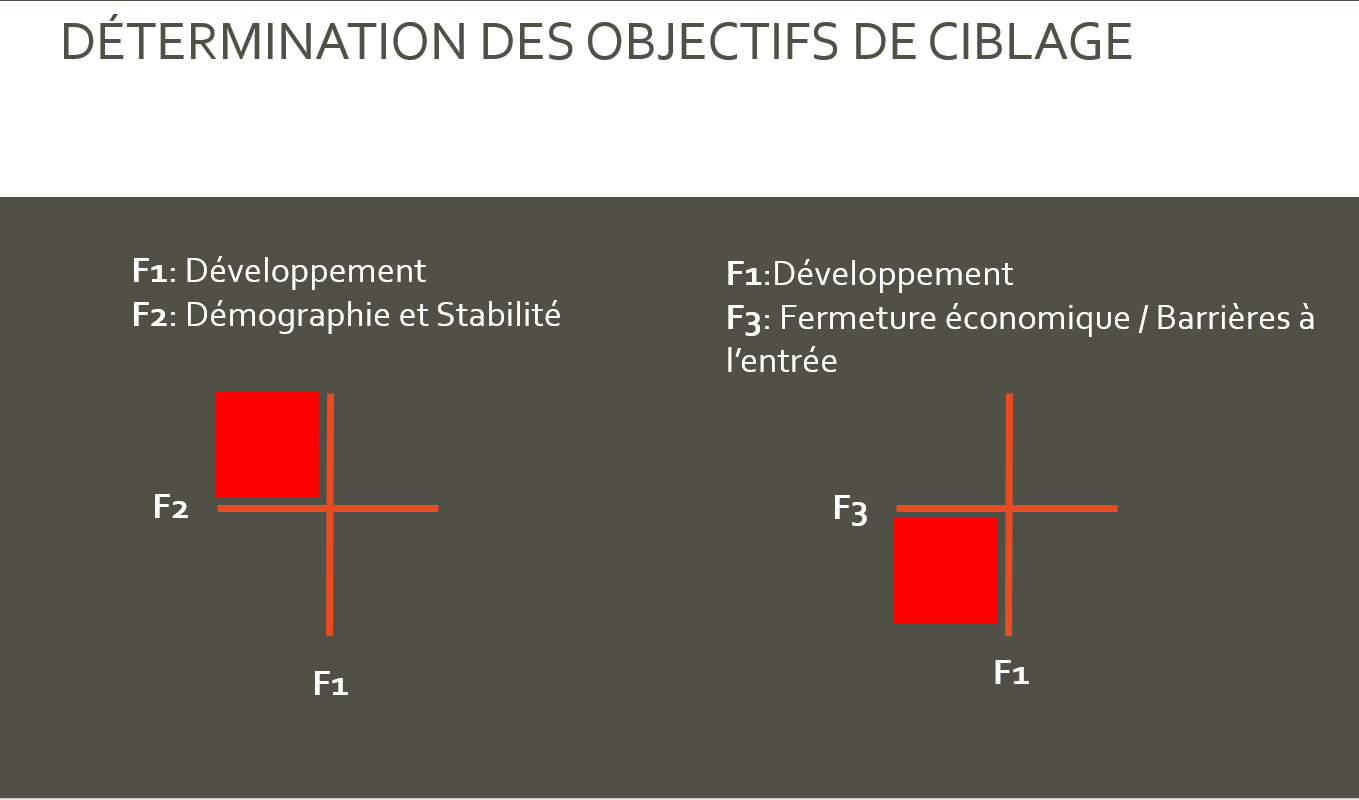

In [41]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-1.08469221, -0.57210654, -0.26492821,  0.23936694, -0.04165784,
         0.00435932],
       [ 0.77031253, -0.3940552 ,  0.57020119,  0.16553305, -0.43708915,
         0.02538955],
       [-0.08437837,  0.28787581, -0.34195593,  0.06135446,  0.29528783,
         0.16280819],
       [-0.18104627, -0.57164623,  0.39472496,  0.05827003,  0.0321701 ,
         0.07389649],
       [ 1.022889  , -0.54179346, -0.40931508,  0.06158185, -0.13183531,
         0.05790329]])

# Création des clusters d'individus

# 1. Clustering via la méthode HAC (Hierarchical Agglomerative Clustering)

## 1.1 Création du dendrogramme

In [42]:
# Chargement du fichier pre-traîté

df = pd.read_csv("tableau_analyse.csv", decimal=".", index_col=0, encoding='latin-1')
df

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant)
Zone,,,,,,,,,,,,,,
Afghanistan,6.0,0.0,36.0,28.0,12.970148,2.316810,508.453722,40099.462,31.618301,0.254138,-2.73,9,0.001671,0.000698
Afrique du Sud,140.0,49.0,425.0,1881.0,3062.256423,-15.113259,5094.384038,59392.255,11.755044,0.672612,-0.24,40,0.034803,0.031671
Albanie,71.0,0.0,26.0,14.0,1069.861314,-3.080819,5180.914198,2854.710,-1.296006,0.637411,0.08,5,0.014012,0.004904
Algérie,22.0,1.0,0.0,284.0,1142.640689,-15.282432,3367.963003,44177.969,18.564953,0.735321,-0.86,18,0.006338,0.006429
Allemagne,67.0,575.0,766.0,1572.0,64589.266093,-1.393035,45908.724713,83408.554,2.284599,0.767204,0.67,8,0.019494,0.018847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,104.0,86.0,493.0,51.0,19884.468665,-15.027324,36284.547906,9365.145,8.080537,0.919767,0.63,4,0.049012,0.005446
Équateur,81.0,0.0,0.0,333.0,1104.193903,-9.998056,5600.391520,17797.737,14.943629,0.632435,-0.36,49,0.018710,0.018710
États-Unis d'Amérique,231.0,3878.0,135.0,23150.0,95037.000000,-2.812720,63122.594145,336997.624,6.425460,0.815543,-0.02,4,0.057719,0.068695


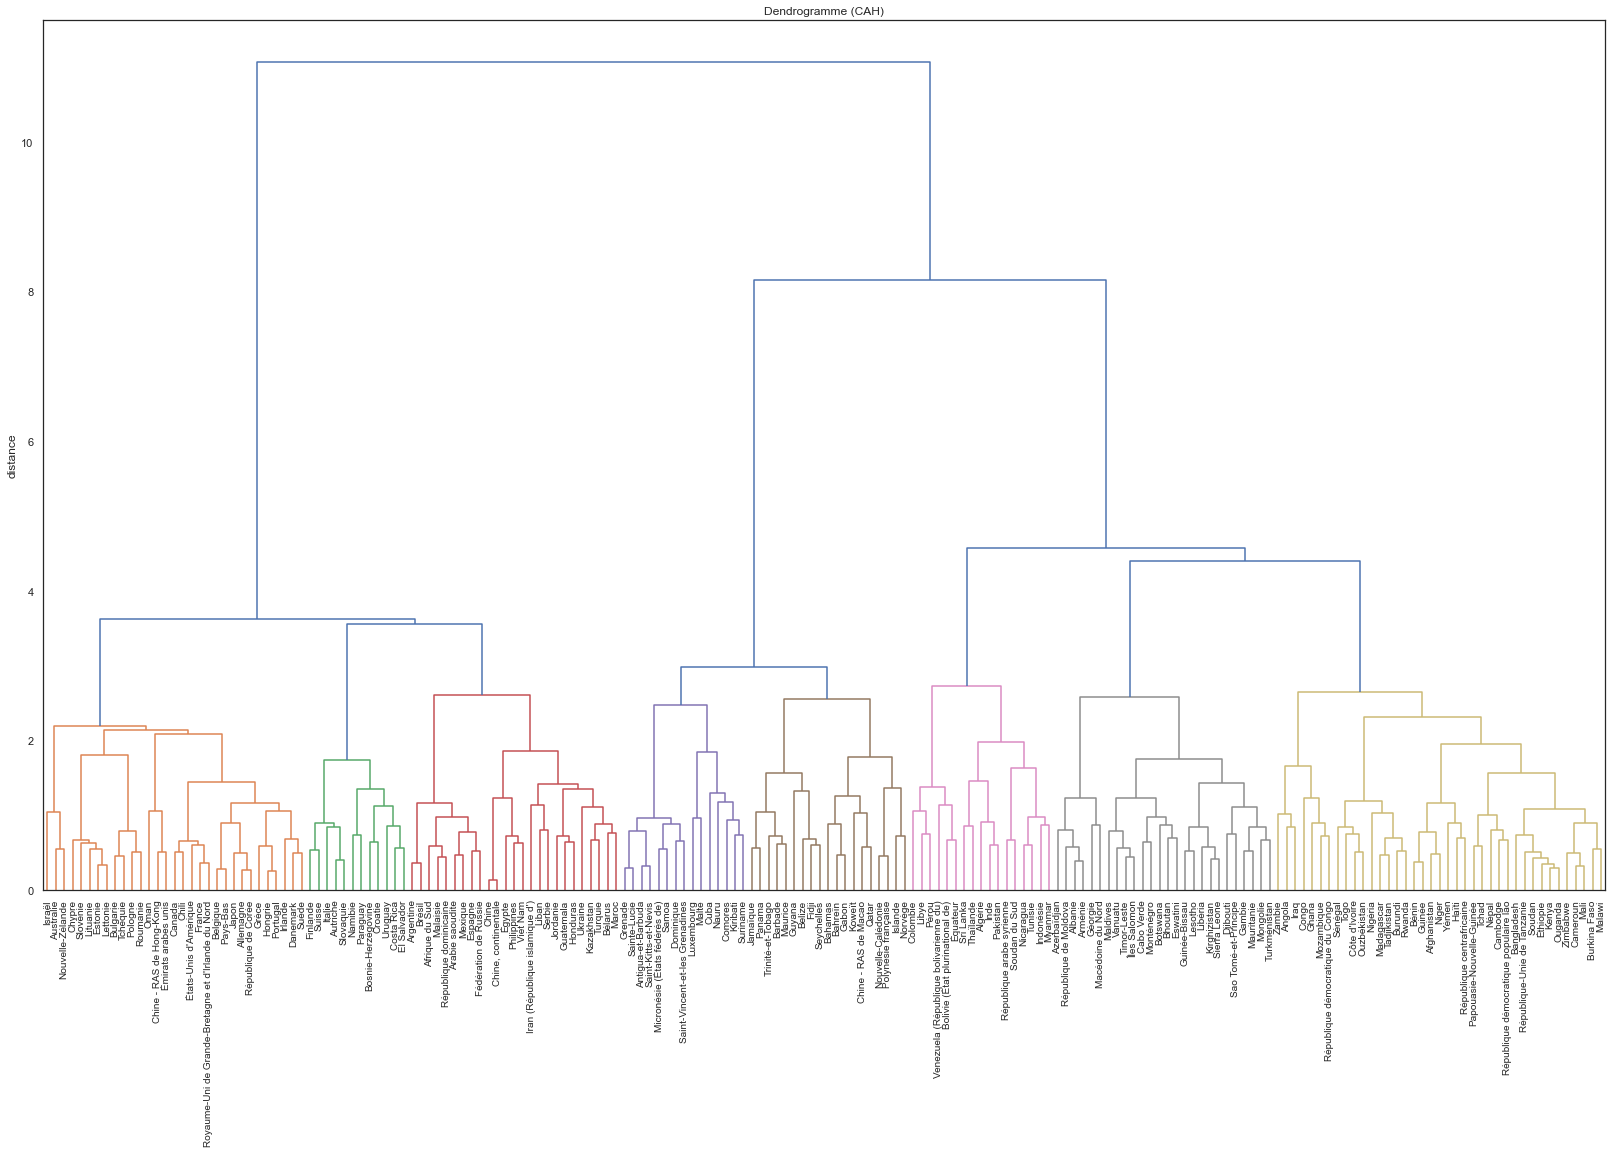

In [43]:
# Selection de la donnée à analyser
Y = df.values
# Standardisation / Fit
standard_scale = QuantileTransformer(n_quantiles=184, output_distribution='uniform').fit(Y)
Y_scaled = standard_scale.transform(Y)
#Clustering (methode de Ward)
Z = linkage(Y_scaled, method = 'ward', metric='euclidean')
#Création du dendrogramme
fig =plt.figure(figsize=(28,16))
sns.set_style('white')
plt.title('Dendrogramme (CAH)')
plt.ylabel('distance')
dendrogram(Z, labels = df.index, leaf_font_size=10, color_threshold=2.8)
    ## Affichage du dendrogramme 
plt.show()

<div class="alert alert-info" role="alert"><b>
Analyse : Lorsqu'on analyse le dendrogramme issu d'une classification ascendante hiérarchique, un total de 8 clusters semblent se dégager. 
</div>

## 1.2 Découpage du dendogramme

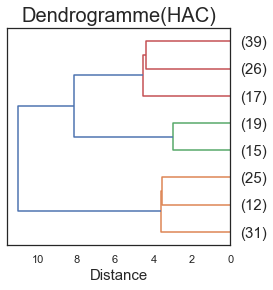

In [44]:
# Création du graph 
fig = plt.figure(figsize=(4,4))
# Setup titres
plt.title('Dendrogramme(HAC)', fontsize=20)
# Setup label
plt.xlabel('Distance', fontsize=15)
# Découpage du dendogramme sur la base du nombre de cluster défini sur le précédent graph
dendrogram(Z, labels = df.index, p=8, truncate_mode='lastp', leaf_font_size=15, orientation='left')
# Affichage
plt.show()

<div class="alert alert-info" role="alert"><b>
Analyse : le découpage en 8 groupes permet d'obtenir un nombre d'individus plutôt homogène. 
</div>

## 1.3 Analyse des clusters

In [45]:
#Identification des 5 groupes obtenus
clusters_cah = fcluster(Z, 8, criterion='maxclust')
#index clusters
index_cah = np.argsort(clusters_cah)
#Ajout de la notion de groupe pour chaque individu
df_cluster = pd.DataFrame(df.index[index_cah], clusters_cah[index_cah]).reset_index()
df_cluster = df_cluster.rename(columns={'index':'Cluster'})
df_cluster.head()

,Cluster,Zone
0,1,Lituanie
1,1,Chine - RAS de Hong-Kong
2,1,Danemark
3,1,Chili
4,1,Canada


In [46]:
# Merge pour ajouter la colonne cluster au df de base 
df_cluster = pd.merge(df, df_cluster, on='Zone')
df_cluster.set_index('Zone', inplace=True)
df_cluster.head()

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant),Cluster
Zone,,,,,,,,,,,,,,,
Afghanistan,6.0,0.0,36.0,28.0,12.970148,2.316810,508.453722,40099.462,31.618301,0.254138,-2.73,9,0.001671,0.000698,8
Afrique du Sud,140.0,49.0,425.0,1881.0,3062.256423,-15.113259,5094.384038,59392.255,11.755044,0.672612,-0.24,40,0.034803,0.031671,3
Albanie,71.0,0.0,26.0,14.0,1069.861314,-3.080819,5180.914198,2854.710,-1.296006,0.637411,0.08,5,0.014012,0.004904,7
Algérie,22.0,1.0,0.0,284.0,1142.640689,-15.282432,3367.963003,44177.969,18.564953,0.735321,-0.86,18,0.006338,0.006429,6
Allemagne,67.0,575.0,766.0,1572.0,64589.266093,-1.393035,45908.724713,83408.554,2.284599,0.767204,0.67,8,0.019494,0.018847,1


### Cluster 1 : 

In [47]:
# création df cluster 1
cluster_1=df_cluster.loc[df_cluster['Cluster']==1]

In [48]:
# liste des individus Cluster 1
names_c1 = cluster_1.index.values.tolist()
nb_c1 = len(names_c1)
print(nb_c1,"", names_c1)

31  ['Allemagne', 'Australie', 'Belgique', 'Bulgarie', 'Canada', 'Chili', 'Chine - RAS de Hong-Kong', 'Chypre', 'Danemark', 'Estonie', 'France', 'Grèce', 'Hongrie', 'Irlande', 'Israël', 'Japon', 'Lettonie', 'Lituanie', 'Nouvelle-Zélande', 'Oman', 'Pays-Bas', 'Pologne', 'Portugal', 'Roumanie', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'République de Corée', 'Slovénie', 'Suède', 'Tchéquie', 'Émirats arabes unis', "États-Unis d'Amérique"]


### Cluster 2 : 

In [49]:
# création df Cluster 2
cluster_2=df_cluster.loc[df_cluster['Cluster']==2]

In [50]:
# liste des individus Cluster 2
names_c2 = cluster_2.index.values.tolist()
nb_c2 = len(names_c2)
print(nb_c2,"", names_c2)

12  ['Autriche', 'Bosnie-Herzégovine', 'Costa Rica', 'Croatie', 'El Salvador', 'Finlande', 'Italie', 'Namibie', 'Paraguay', 'Slovaquie', 'Suisse', 'Uruguay']


### Cluster 3 : 

In [51]:
# création df Cluster 3
cluster_3=df_cluster.loc[df_cluster['Cluster']==3]

In [52]:
# liste des individus Cluster 3
names_c3 = cluster_3.index.values.tolist()
nb_c3 = len(names_c3)
print(nb_c3,"", names_c3)

25  ['Afrique du Sud', 'Arabie saoudite', 'Argentine', 'Brésil', 'Bélarus', 'Chine', 'Chine, continentale', 'Espagne', 'Fédération de Russie', 'Guatemala', 'Honduras', "Iran (République islamique d')", 'Jordanie', 'Kazakhstan', 'Liban', 'Malaisie', 'Maroc', 'Mexique', 'Philippines', 'République dominicaine', 'Serbie', 'Turquie', 'Ukraine', 'Viet Nam', 'Égypte']


### Cluster 4 : 

In [53]:
# création df Cluster 4
cluster_4=df_cluster.loc[df_cluster['Cluster']==4]

In [54]:
# liste des individus Cluster 4
names_c4 = cluster_4.index.values.tolist()
nb_c4 = len(names_c4)
print(nb_c4,"", names_c4)

15  ['Antigua-et-Barbuda', 'Comores', 'Cuba', 'Dominique', 'Grenade', 'Kiribati', 'Luxembourg', 'Malte', 'Micronésie (États fédérés de)', 'Nauru', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa', 'Suriname']


### Cluster 5 : 

In [55]:
# création df Cluster 5
cluster_5=df_cluster.loc[df_cluster['Cluster']==5]

In [56]:
# liste des individus Cluster 5
names_c5 = cluster_5.index.values.tolist()
nb_c5 = len(names_c5)
print(nb_c5,"", names_c5)

19  ['Bahamas', 'Bahreïn', 'Barbade', 'Belize', 'Chine - RAS de Macao', 'Fidji', 'Gabon', 'Guyana', 'Islande', 'Jamaïque', 'Koweït', 'Maurice', 'Norvège', 'Nouvelle-Calédonie', 'Panama', 'Polynésie française', 'Qatar', 'Seychelles', 'Trinité-et-Tobago']


### Cluster 6 : 

In [57]:
# création df Cluster 6
cluster_6=df_cluster.loc[df_cluster['Cluster']==6]

In [58]:
# liste des individus Cluster 6
names_c6 = cluster_6.index.values.tolist()
nb_c6 = len(names_c6)
print(nb_c6,"", names_c6)

17  ['Algérie', 'Bolivie (État plurinational de)', 'Colombie', 'Inde', 'Indonésie', 'Libye', 'Myanmar', 'Nicaragua', 'Pakistan', 'Pérou', 'République arabe syrienne', 'Soudan du Sud', 'Sri Lanka', 'Thaïlande', 'Tunisie', 'Venezuela (République bolivarienne du)', 'Équateur']


### Cluster 7 : 

In [59]:
# création df Cluster 7
cluster_7=df_cluster.loc[df_cluster['Cluster']==7]

In [60]:
# liste des individus Cluster 7
names_c7 = cluster_7.index.values.tolist()
nb_c7 = len(names_c7)
print(nb_c7,"", names_c7)

26  ['Albanie', 'Arménie', 'Azerbaïdjan', 'Bhoutan', 'Botswana', 'Cabo Verde', 'Djibouti', 'Eswatini', 'Gambie', 'Guinée-Bissau', 'Géorgie', 'Kirghizistan', 'Lesotho', 'Libéria', 'Macédoine du Nord', 'Maldives', 'Mauritanie', 'Mongolie', 'Monténégro', 'République de Moldova', 'Sao Tomé-et-Principe', 'Sierra Leone', 'Timor-Leste', 'Turkménistan', 'Vanuatu', 'Îles Salomon']


### Cluster 8 : 

In [61]:
# création df Cluster 8
cluster_8=df_cluster.loc[df_cluster['Cluster']==8]

In [62]:
# liste des individus Cluster 8
names_c8 = cluster_8.index.values.tolist()
nb_c8 = len(names_c8)
print(nb_c8,"", names_c8)

39  ['Afghanistan', 'Angola', 'Bangladesh', 'Burkina Faso', 'Burundi', 'Bénin', 'Cambodge', 'Cameroun', 'Congo', "Côte d'Ivoire", 'Ghana', 'Guinée', 'Haïti', 'Iraq', 'Kenya', 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Niger', 'Nigéria', 'Népal', 'Ouganda', 'Ouzbékistan', 'Papouasie-Nouvelle-Guinée', 'Rwanda', 'République centrafricaine', 'République démocratique du Congo', 'République démocratique populaire lao', 'République-Unie de Tanzanie', 'Soudan', 'Sénégal', 'Tadjikistan', 'Tchad', 'Togo', 'Yémen', 'Zambie', 'Zimbabwe', 'Éthiopie']


## Heatmap de correlation des variables par cluster

C:\Users\ptigr\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (184). n_quantiles is set to n_samples.
  warnings.warn(


Text(66.5, 0.5, 'cluster')

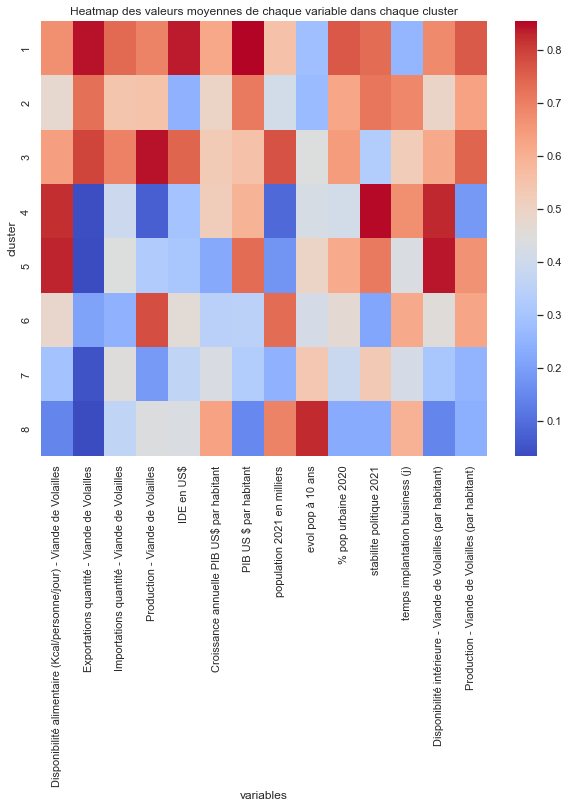

In [63]:
# Heatmap variable x cluster

cluster_data = df_cluster.drop(columns = 'Cluster')
scaler  = QuantileTransformer()
data_fit  = scaler.fit(cluster_data)
data_scaled  = data_fit.transform(cluster_data)
data_scaled = pd.DataFrame(data_scaled)
name_columns = cluster_data.columns.tolist()
data_scaled.columns = name_columns
data_test = df_cluster.reset_index()
data_scaled_with_cluster = data_scaled.merge(data_test[['Cluster']], left_index=True, right_index=True) 

plt.figure(figsize=(10,8))
sns.heatmap(data_scaled_with_cluster.groupby('Cluster').mean(), cmap='coolwarm')
plt.title('Heatmap des valeurs moyennes de chaque variable dans chaque cluster')
plt.xlabel('variables')
plt.ylabel('cluster')

## Projection des individus et clusters sur les composantes principales

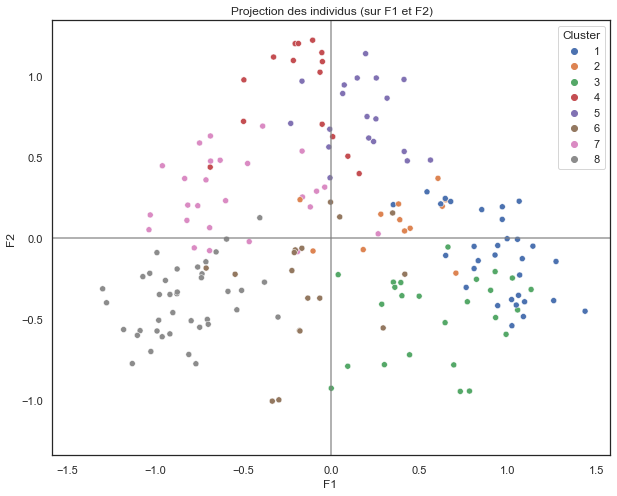

In [64]:
# projection des individus sur 2 composantes selectionnées
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=df_cluster['Cluster'])

<div class="alert alert-info" role="alert

F1 = Abondance
- C1: très abondants (+ à +++)
- C2: peu abondants (-)
- C3: peu abondants (-)
    
F2 = Stabilité 
- C1: varie selon les individus de très instable (---) à très stable (+++)
- C2: de stable (+) à instable (--)
- C3: plutôt stable (++)
    
</div>

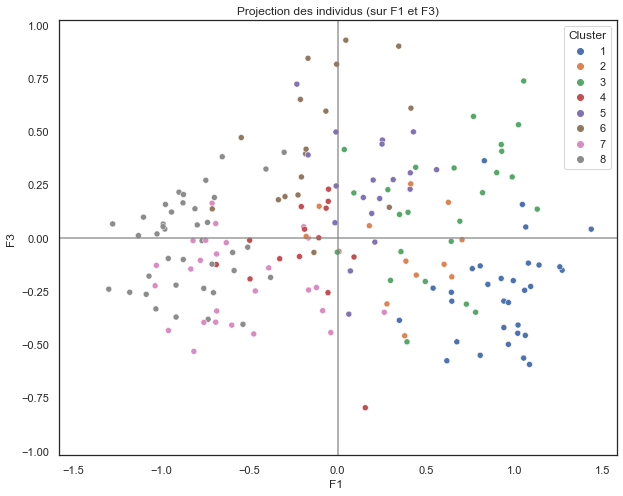

In [65]:
# projection des individus sur 2 composantes selectionnées
x_y = [0,2]
display_factorial_planes(X_proj, x_y, clusters=df_cluster['Cluster'])

<div class="alert alert-info" role="alert">
ANALYSE DE LA PROJECTION DES INDIVIDUS SUR LES COMPOSANTES PRINCIPALES :
    
- C1: Pays très développés, avec une stabilité politique négative et une population importante, ouverts économiquement.

- C2: Pays plutôt développés, avec une stabilité politique plutôt positive et une population moyenne, majoritairement ouverts économiquement.

- C3: Pays développés, avec une stabilité politique négative et une population importante, majoritairement fermés économiquement.

- C4: Pays peu développés, avec une bonne stabilité politique et une population faible, plutôt fermés économiquement.

- C5: Pays développés, avec une bonne stabilité politique et une population faible, ouverts économiquement.

- C6: Pays peu développés, faible stabilité politique et population plutôt importante, fermés économiquement.

- C7: Pays peu développés, bonne stabilité politique, population moyenne à faible, ouverts économiquement.

- C8: Pays très peu développés, peu stables politiquement et une ouverture économique variant en fonction des individus.

    
</div> 

<div class="alert alert-success" role="alert"> Le cluster 7 correspond à nos objectifs de ciblage !
</div>

In [66]:
cluster_7.shape

(26, 15)

In [67]:
cluster_7

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant),Cluster
Zone,,,,,,,,,,,,,,,
Albanie,71.0,0.0,26.0,14.0,1069.861314,-3.080819,5180.914198,2854.710,-1.296006,0.637411,0.08,5,0.014012,0.004904,7
Arménie,51.0,0.0,33.0,12.0,344.192742,-7.354230,4266.005479,2790.974,-4.235730,0.663155,-0.57,4,0.016482,0.004300,7
Azerbaïdjan,48.0,0.0,31.0,115.0,507.000000,-12.353887,4202.232239,10312.992,8.722886,0.553812,-0.73,4,0.014157,0.011151,7
Bhoutan,15.0,0.0,2.0,2.0,0.610090,-2.962082,3217.962935,777.486,7.812715,0.457530,1.02,12,0.005145,0.002572,7
Botswana,12.0,0.0,5.0,4.0,31.807195,-15.806134,6710.960147,2588.423,18.984704,0.672404,1.09,48,0.003091,0.001545,7
Cabo Verde,67.0,0.0,14.0,1.0,54.922920,-14.970549,3064.276546,587.925,10.126362,0.649025,0.88,9,0.018710,0.001701,7
Djibouti,12.0,0.0,4.0,0.0,158.230011,6.540509,3465.038713,1105.557,15.850411,0.715987,-0.32,14,0.003618,0.000000,7
Eswatini,25.0,0.0,2.0,6.0,40.919495,-15.110259,3305.774271,1192.271,7.272251,0.294663,-0.12,22,0.006710,0.005032,7
Gambie,35.0,0.0,24.0,2.0,189.576191,-1.532299,757.412441,2639.916,28.088213,0.557619,0.25,8,0.009849,0.000758,7


In [68]:
print(names_c7)

['Albanie', 'Arménie', 'Azerbaïdjan', 'Bhoutan', 'Botswana', 'Cabo Verde', 'Djibouti', 'Eswatini', 'Gambie', 'Guinée-Bissau', 'Géorgie', 'Kirghizistan', 'Lesotho', 'Libéria', 'Macédoine du Nord', 'Maldives', 'Mauritanie', 'Mongolie', 'Monténégro', 'République de Moldova', 'Sao Tomé-et-Principe', 'Sierra Leone', 'Timor-Leste', 'Turkménistan', 'Vanuatu', 'Îles Salomon']


# Détermination des clusters via la méthode KMeans

## 1. Détermination du nombre de clusters via KMeans

## 1.1 Méthode du coude

In [108]:
# Création d'un dataframe sur la base du df initial
setup_kmeans = df

In [109]:
# scaling du dataset pour utilisation via kmeans
scaler = QuantileTransformer(n_quantiles=184, output_distribution='uniform')
data = scaler.fit(setup_kmeans)
data_scaled = data.transform(setup_kmeans)

In [110]:
# Calcul de l'inertie pour un nombre de clusters donné
kmeans = KMeans(n_clusters=8)
kmeans.fit(data_scaled)
kmeans.inertia_

96.54143519938997

In [111]:
# Création du tableau d'inertie et du range
inertia = []
k_list = range(1, 10)
list(k_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [112]:
# Remplissage du tableau d'inertie
for i in k_list :
    kmeans_inertia = KMeans(n_clusters=i)
    kmeans_inertia.fit(data_scaled)
    inertia.append(kmeans_inertia.inertia_)

C:\Users\ptigr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


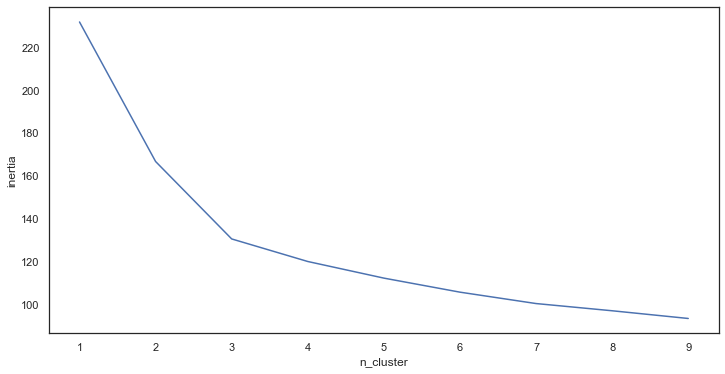

In [113]:
# Visualisation méthode du coude 
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("inertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, inertia)

<div class="alert alert-info" role="alert"><b>
Analyse: la cassure s'opère à partir de 3 clusters et l'inertie commence à devenir résiduelle à partir de ce chiffre. 
    </b></div>

## 1.2 Coefficient de silhouette

In [114]:
# calcule du silhouette score pour chaque nombre de cluster possible
from sklearn.metrics import silhouette_score
tab_silhouette =[]
k_range=range(2,10)
for k in k_range:
    model=KMeans(n_clusters=k)
    cluster_labels=model.fit_predict(data_scaled)
    tab_silhouette.append(silhouette_score(data_scaled,cluster_labels))

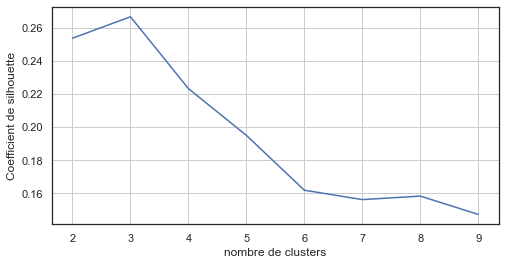

[0.25370230988697434,
 0.26666958920134254,
 0.22323822163722556,
 0.1949767890732941,
 0.1618536193678903,
 0.15617801460065034,
 0.15829872905808198,
 0.14723070992804888]

In [115]:
# visualisation coefficient de silhouette
fig = plt.figure(figsize=(8,4))
plt.plot(k_range,tab_silhouette)
plt.xlabel('nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.grid()
plt.show()
tab_silhouette

<div class="alert alert-info" role="alert"><b>
Analyse : le nombre de clusters avec le meilleur <i>silhouette score</i> est de 3.
    </b></div>

<div class="alert alert-warning" role="alert"><b>
Attention: le nombre de clusters recommandé (3) via la méthode du coude / le coefficient de silhouette impliquait des clusters beaucoup trop hétérogènes (avec un cluster comprenant à lui seul près de 70% des pays), ne permettant ainsi pas d'analyse pertinente. Après expérimentation de différentes valeurs, c'est le nombre de 8 clusters qui a été retenu, les clusters étant plus homogènes en taille et permettant un comparatif pertinent avec les clusters issus de la CAH, ainsi qu'un positionnement clairement marqué et distinctif des différents clusters sur les composantes de l'ACP.
    </b></div>

## 1.3 Visualisation des clusters

Inertie totale : 63.44911956850205


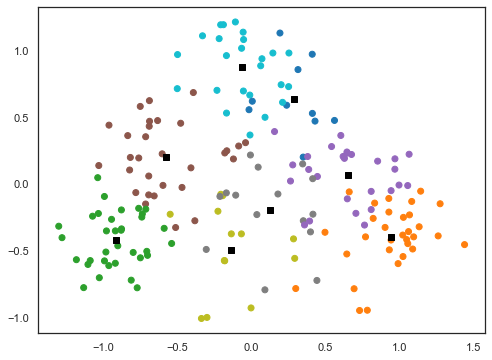

In [116]:
# Affichage du nuage de points (individus) en cluster avec les centroîdes
fig = plt.figure(figsize=(8,6))

model = KMeans(n_clusters=8)
model.fit(X_proj)
model.predict(X_proj)

plt.scatter(X_proj[:,0], 
            X_proj[:,1],
            c=model.predict(X_proj),cmap='tab10')
plt.scatter(model.cluster_centers_[:,0], 
           model.cluster_centers_[:,1],
           marker='s',c='black')


print('Inertie totale :',model.inertia_)


In [117]:
# setup nb cluster + fit du set de données
kmeans = KMeans(n_clusters=8)
kmeans.fit(data_scaled)

KMeans()

In [118]:
# label clustering
kmeans.labels_

array([2, 1, 6, 7, 1, 0, 3, 1, 1, 6, 1, 6, 7, 5, 5, 2, 4, 1, 4, 0, 5, 6,
       0, 1, 6, 2, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 5, 1, 6, 5, 0, 0, 6, 6,
       3, 2, 1, 0, 3, 6, 1, 6, 0, 4, 6, 1, 1, 5, 0, 2, 3, 1, 1, 2, 0, 4,
       6, 2, 7, 1, 7, 7, 7, 7, 1, 4, 1, 1, 5, 1, 1, 1, 2, 0, 4, 5, 0, 6,
       6, 5, 0, 6, 6, 6, 2, 1, 2, 0, 2, 4, 7, 4, 0, 1, 3, 0, 4, 2, 7, 0,
       3, 7, 2, 2, 5, 3, 1, 2, 6, 2, 2, 7, 5, 0, 7, 1, 7, 1, 3, 1, 5, 5,
       1, 1, 2, 7, 2, 1, 6, 1, 2, 0, 2, 3, 3, 3, 3, 0, 6, 4, 0, 6, 6, 2,
       2, 7, 6, 4, 1, 2, 2, 2, 1, 7, 0, 2, 5, 7, 0, 1, 1, 6, 0, 7, 1, 2,
       0, 2, 7, 1, 7, 1, 2, 0])

In [119]:
# setup renaming cluster
dd = {i:j for i,j in enumerate(list("abcdefgh"))}
dd

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}

In [120]:
# gestion labels
labels = [dd[i] for i in kmeans.labels_]
labels[:10]

['c', 'b', 'g', 'h', 'b', 'a', 'd', 'b', 'b', 'g']

In [121]:
# ajout de la lettre correspondant au cluster dans une colonne dédiée
setup_kmeans["cluster"] = labels

In [122]:
# visualisation du df setup_kmeans
setup_kmeans

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant),cluster
Zone,,,,,,,,,,,,,,,
Afghanistan,6.0,0.0,36.0,28.0,12.970148,2.316810,508.453722,40099.462,31.618301,0.254138,-2.73,9,0.001671,0.000698,c
Afrique du Sud,140.0,49.0,425.0,1881.0,3062.256423,-15.113259,5094.384038,59392.255,11.755044,0.672612,-0.24,40,0.034803,0.031671,b
Albanie,71.0,0.0,26.0,14.0,1069.861314,-3.080819,5180.914198,2854.710,-1.296006,0.637411,0.08,5,0.014012,0.004904,g
Algérie,22.0,1.0,0.0,284.0,1142.640689,-15.282432,3367.963003,44177.969,18.564953,0.735321,-0.86,18,0.006338,0.006429,h
Allemagne,67.0,575.0,766.0,1572.0,64589.266093,-1.393035,45908.724713,83408.554,2.284599,0.767204,0.67,8,0.019494,0.018847,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,104.0,86.0,493.0,51.0,19884.468665,-15.027324,36284.547906,9365.145,8.080537,0.919767,0.63,4,0.049012,0.005446,b
Équateur,81.0,0.0,0.0,333.0,1104.193903,-9.998056,5600.391520,17797.737,14.943629,0.632435,-0.36,49,0.018710,0.018710,h
États-Unis d'Amérique,231.0,3878.0,135.0,23150.0,95037.000000,-2.812720,63122.594145,336997.624,6.425460,0.815543,-0.02,4,0.057719,0.068695,b


In [123]:
# cluster a visualisations
cluster_a = setup_kmeans.loc[setup_kmeans['cluster'] == 'a', :]
names_a = cluster_a.index.values.tolist()
print(len(names_a),'',names_a)

26  ['Angola', 'Bhoutan', 'Botswana', 'Cabo Verde', 'Comores', 'Congo', 'Djibouti', 'Eswatini', 'Gambie', 'Guinée-Bissau', 'Kirghizistan', 'Lesotho', 'Libéria', 'Maldives', 'Mauritanie', 'Mongolie', 'Namibie', 'Papouasie-Nouvelle-Guinée', 'République démocratique populaire lao', 'Sao Tomé-et-Principe', 'Sierra Leone', 'Timor-Leste', 'Turkménistan', 'Vanuatu', 'Zambie', 'Îles Salomon']


In [124]:
# cluster b visualisations
cluster_b = setup_kmeans.loc[setup_kmeans['cluster'] == 'b', :]
names_b = cluster_b.index.values.tolist()
print(len(names_b),'',names_b)

43  ['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Argentine', 'Australie', 'Belgique', 'Brésil', 'Bélarus', 'Canada', 'Chili', 'Chine', 'Chine - RAS de Hong-Kong', 'Chine, continentale', 'Danemark', 'Espagne', 'France', 'Fédération de Russie', 'Grèce', 'Guatemala', 'Hongrie', 'Irlande', 'Israël', 'Italie', 'Japon', 'Jordanie', 'Kazakhstan', 'Malaisie', 'Mexique', 'Nouvelle-Zélande', 'Pays-Bas', 'Pologne', 'Portugal', 'Roumanie', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'République de Corée', 'République dominicaine', 'Suède', 'Tchéquie', 'Turquie', 'Ukraine', 'Viet Nam', 'Émirats arabes unis', "États-Unis d'Amérique"]


In [125]:
# cluster c visualisations
cluster_c = setup_kmeans.loc[setup_kmeans['cluster'] == 'c', :]
names_c = cluster_c.index.values.tolist()
print(len(names_c),'',names_c)

34  ['Afghanistan', 'Bangladesh', 'Burkina Faso', 'Burundi', 'Bénin', 'Cambodge', 'Cameroun', "Côte d'Ivoire", 'Ghana', 'Guinée', 'Haïti', 'Kenya', 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Niger', 'Nigéria', 'Népal', 'Ouganda', 'Ouzbékistan', 'Rwanda', 'République centrafricaine', 'République démocratique du Congo', 'République-Unie de Tanzanie', 'Soudan', 'Soudan du Sud', 'Sénégal', 'Tadjikistan', 'Tchad', 'Togo', 'Yémen', 'Zimbabwe', 'Éthiopie']


In [126]:
# cluster d visualisations
cluster_d = setup_kmeans.loc[setup_kmeans['cluster'] == 'd', :]
names_d = cluster_d.index.values.tolist()
print(len(names_d),'',names_d)

12  ['Antigua-et-Barbuda', 'Cuba', 'Dominique', 'Grenade', 'Micronésie (États fédérés de)', 'Nauru', 'Nouvelle-Calédonie', 'Polynésie française', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa']


In [127]:
# cluster e visualisations
cluster_e = setup_kmeans.loc[setup_kmeans['cluster'] == 'e', :]
names_e = cluster_e.index.values.tolist()
print(len(names_e),'',names_e)

11  ['Barbade', 'Belize', 'Fidji', 'Guyana', 'Islande', 'Kiribati', 'Malte', 'Maurice', 'Monténégro', 'Seychelles', 'Suriname']


In [128]:
# cluster f visualisations
cluster_f = setup_kmeans.loc[setup_kmeans['cluster'] == 'f', :]
names_f = cluster_f.index.values.tolist()
print(len(names_f),'',names_f)

14  ['Bahamas', 'Bahreïn', 'Bolivie (État plurinational de)', 'Chine - RAS de Macao', 'Colombie', 'Gabon', 'Jamaïque', 'Koweït', 'Libye', 'Norvège', 'Panama', 'Pérou', 'Qatar', 'Trinité-et-Tobago']


In [129]:
# cluster g visualisations
cluster_g = setup_kmeans.loc[setup_kmeans['cluster'] == 'g', :]
names_g = cluster_g.index.values.tolist()
print(len(names_g),'',names_g)

24  ['Albanie', 'Arménie', 'Autriche', 'Bosnie-Herzégovine', 'Bulgarie', 'Chypre', 'Costa Rica', 'Croatie', 'El Salvador', 'Estonie', 'Finlande', 'Géorgie', 'Lettonie', 'Liban', 'Lituanie', 'Luxembourg', 'Macédoine du Nord', 'Oman', 'République de Moldova', 'Serbie', 'Slovaquie', 'Slovénie', 'Suisse', 'Uruguay']


In [130]:
# cluster h visualisations
cluster_h = setup_kmeans.loc[setup_kmeans['cluster'] == 'h', :]
names_h = cluster_h.index.values.tolist()
print(len(names_h),'',names_h)

20  ['Algérie', 'Azerbaïdjan', 'Honduras', 'Inde', 'Indonésie', "Iran (République islamique d')", 'Iraq', 'Maroc', 'Myanmar', 'Nicaragua', 'Pakistan', 'Paraguay', 'Philippines', 'République arabe syrienne', 'Sri Lanka', 'Thaïlande', 'Tunisie', 'Venezuela (République bolivarienne du)', 'Égypte', 'Équateur']


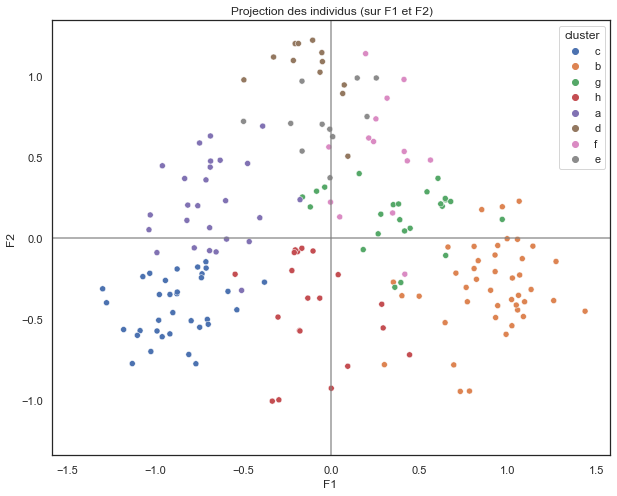

In [131]:
# projection des individus sur 2 composantes selectionnées
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=setup_kmeans['cluster'])

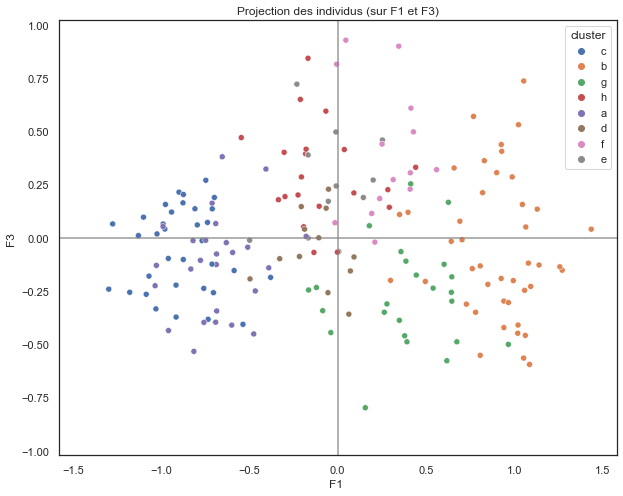

In [132]:
# projection des individus sur 2 composantes selectionnées
x_y = [0,2]
display_factorial_planes(X_proj, x_y, clusters=setup_kmeans['cluster'])

<div class="alert alert-info" role="alert">
ANALYSE DE LA PROJECTION DES INDIVIDUS SUR LES COMPOSANTES PRINCIPALES : <br> 
 
A: Pays peu développés, avec une stabilité politique négative et une population importante, ouverts économiquement.

B: Pays peu développés, avec une stabilité politique positive et une population moyenne à faible, ouverts économiquement.

C: Pays développés, avec une stabilité politique et population variant selon les pays, ouverts économiquement.

D: Pays très développés, avec une stabilité politique faible et une population élevée, majoritairement ouverts économiquement.

E: Pays plutôt peu développés, avec une bonne stabilité politique et une population faible, fermés économiquement.

F: Pays très peu développés, stabilité politique négative et population importante, plutôt ouverts économiquement mais variant selon les individus.

G: Pays plutôt développés, bonne stabilité politique et population moyenne à faible, fermés économiquement.

H: Pays développés, peu stables politiquement avec une population assez importante et fermés économiquement.
</div> 

<div class="alert alert-success" role="alert"> Le cluster B correspond à nos objectifs de ciblage !
</div>

# RESULTATS / RECOMMANDATIONS : 

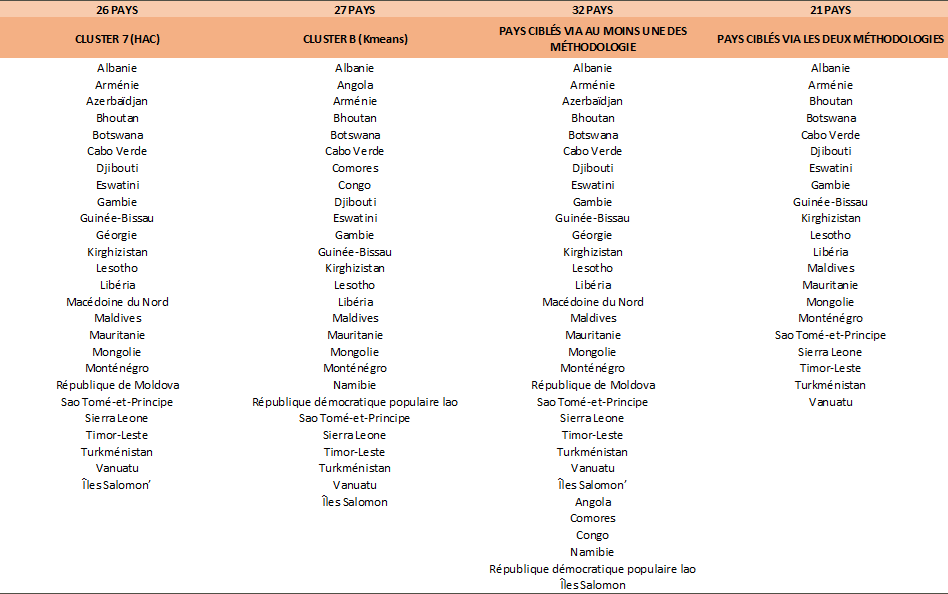

<div class="alert alert-info" role="alert"><b>
Si l'on souhaite cibler large on peut se focaliser sur la liste des 32 pays qui ont étés retenus via au moins une des deux méthodologies. 

Le plus pertinent serait néanmoins de se focaliser sur les 21 pays retenus conjointement via les deux methodologies et qui semblent donc les plus à même de correspondre aux objectifs ciblés.

Afin d'aller plus loin et d'aboutir sur une shortlist pertinente, des études complémentaires sont envisageables via une analyse des variables au cas par cas et la prise en compte de données quantitatives absentes de cette analyse pour des raisons techniques (ex: culture et histoire du pays / géopolitique / structures logistiques / accords commerciaux pré-existants avec notre pays / présence de concurrence etc...).

</div>